In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"./data/{prefix}_message_5.csv"
orderbook_data_file = f"./data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction',
),
    skiprows=1
)

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)
df['event_lapse'] = df['time'].diff().fillna(0)

df = df[df['type'] != 5]

In [15]:
tick_size = 100

midprice = (df['bid1_price'] + df["ask1_price"]) / 2
midpricePlusTick = midprice + tick_size / 2
midpriceSubTick = midprice - tick_size / 2
spread = df["ask1_price"] - df['bid1_price']

conditions = [
    spread == tick_size,
    df["ask1_price"] >= df['bid1_price'],
    df["ask1_price"] < df['bid1_price']
]

choices = [
    midprice,
    midpricePlusTick,
    midpriceSubTick
]

df['reference_price'] = np.select(conditions, choices)

for n in range(0, 3):
    bid_price_level = df['reference_price'] - (tick_size / 2) - (tick_size * n)
    ask_price_level = df['reference_price'] + (tick_size / 2) + (tick_size * n)

    bid_conditions = [
        bid_price_level == df['bid1_price'],
        bid_price_level == df['bid2_price'],
        bid_price_level == df['bid3_price'],
        bid_price_level == df['bid4_price'],
        bid_price_level == df['bid5_price'],
    ]
    ask_conditions = [
        ask_price_level == df['ask1_price'],
        ask_price_level == df['ask2_price'],
        ask_price_level == df['ask3_price'],
        ask_price_level == df['ask4_price'],
        ask_price_level == df['ask5_price'],
    ]

    bid_choices = [
        df['bid1_size'].astype(float),
        df['bid2_size'].astype(float),
        df['bid3_size'].astype(float),
        df['bid4_size'].astype(float),
        df['bid5_size'].astype(float)
    ]
    ask_choices = [
        df['ask1_size'],
        df['ask2_size'],
        df['ask3_size'],
        df['ask4_size'],
        df['ask5_size']
    ]

    df[f'norm_bid{n + 1}_price'] = bid_price_level
    df[f'norm_ask{n + 1}_price'] = ask_price_level
    df[f'norm_bid{n + 1}_size'] = np.select(bid_conditions, bid_choices)
    df[f'norm_ask{n + 1}_size'] = np.select(ask_conditions, ask_choices)

# print(df['ask1_price'], df['bid1_price'], df['reference_price'])
# print(df)

In [22]:
DEPTH = 3
ORDER_TYPES = 3

NORMALIZED_QUEUE_MAX = 50

# Orderbook depth, ordertype (limit, market, cancelation), depth of queue storage we are tracking
lambdas = np.zeros((DEPTH, 2, ORDER_TYPES, NORMALIZED_QUEUE_MAX))

event_in_bid = [
    (df['norm_bid1_price'] == df['price']),
    (df['norm_bid2_price'] == df['price']),
    (df['norm_bid3_price'] == df['price']),
]
event_in_ask = [
    (df['norm_ask1_price'] == df['price']),
    (df['norm_ask2_price'] == df['price']),
    (df['norm_ask3_price'] == df['price']),
]

aes_bids = [
    df[event_in_bid[0]]['size'].mean(),
    df[event_in_bid[1]]['size'].mean(),
    df[event_in_bid[2]]['size'].mean()
]
aes_asks = [
    df[event_in_bid[0]]['size'].mean(),
    df[event_in_bid[1]]['size'].mean(),
    df[event_in_bid[2]]['size'].mean()
]

bids_all_depths = df.loc[event_in_bid[0] | event_in_bid[1] | event_in_bid[2]]
asks_all_depths = df.loc[event_in_ask[0] | event_in_ask[1] | event_in_ask[2]]

dt_orders = np.zeros((DEPTH, NORMALIZED_QUEUE_MAX))

for depth_level in range(0, DEPTH):
    bids_at_depth = df.loc[event_in_bid[depth_level]]
    asks_at_depth = df.loc[event_in_ask[depth_level]]

    bid_queue_length = np.ceil(bids_at_depth[f'norm_bid{depth_level + 1}_size'].astype(float) / aes_bids[depth_level])
    ask_queue_length = np.ceil(asks_at_depth[f'norm_ask{depth_level + 1}_size'].astype(float) / aes_asks[depth_level])

    matchesEitherQueue = pd.concat([bids_at_depth, asks_at_depth]).sort_values(['time'])

    dt_order = matchesEitherQueue['time'].diff().fillna(0).mean()

    for queue_index in range(0, NORMALIZED_QUEUE_MAX):

        isBidQueueCurrentLength = (bid_queue_length == queue_index)
        bid_queue = bids_at_depth.loc[isBidQueueCurrentLength]
        
        bidLimitOrder = (bid_queue['type'] == 1)
        bidCancelOrder = (bid_queue['type'] == 2) | (bid_queue['type'] == 3)
        bidMarketOrderCondititons = (
            (bid_queue['type'] == 4) &
            (bid_queue[f'norm_bid{depth_level + 1}_size'] > 0) &
            (bid_queue['direction'] == 1)
        )

        isAskQueueCurrentLength = (ask_queue_length == queue_index)
        ask_queue = asks_at_depth.loc[isAskQueueCurrentLength]
        
        askLimitOrder = (ask_queue['type'] == 1)
        askCancelOrder = (ask_queue['type'] == 2) | (ask_queue['type'] == 3)
        askMarketOrderCondititons = (
            (ask_queue['type'] == 4) &
            (ask_queue[f'norm_ask{depth_level + 1}_size'] > 0) &
            (ask_queue['direction'] == -1)
        )

        lambdas[depth_level, 0, 0, queue_index] = (len(bid_queue[bidLimitOrder])) / (len(matchesEitherQueue) * dt_order)

        lambdas[depth_level, 0, 1, queue_index] = (len(bid_queue[bidMarketOrderCondititons])) / (len(matchesEitherQueue) * dt_order)

        lambdas[depth_level, 0, 2, queue_index] = (len(bid_queue[bidCancelOrder])) / (len(matchesEitherQueue) * dt_order)

        lambdas[depth_level, 1, 0, queue_index] = (len(ask_queue[askLimitOrder])) / (len(matchesEitherQueue) * dt_order)

        lambdas[depth_level, 1, 1, queue_index] = (len(ask_queue[askMarketOrderCondititons])) / (len(matchesEitherQueue) * dt_order)

        lambdas[depth_level, 1, 2, queue_index] = (len(ask_queue[askCancelOrder])) / (len(matchesEitherQueue) * dt_order)
        
        if(queue_index == 10):
            # display(matchesEitherQueue['time'])
            print(matchesEitherQueue['time'].diff().sum())
            print(len(matchesEitherQueue['time'].diff()))
            print(dt_order)
            # display(bid_queue)
            # display(bid_queue[bidLimitOrder])
            # display(bid_queue[bidMarketOrderCondititons])
            # display(bid_queue[bidCancelOrder])
            # plt.scatter(matchesEitherQueue['time'], matchesEitherQueue['price'], s=1)
    print()

23399.942200614
322744
0.0725031052494051

23399.811771668
165387
0.14148519394914957

23399.821097581997
45252
0.5171002629183682



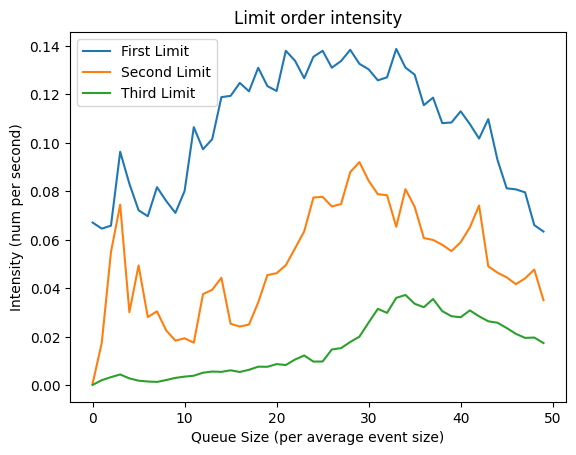

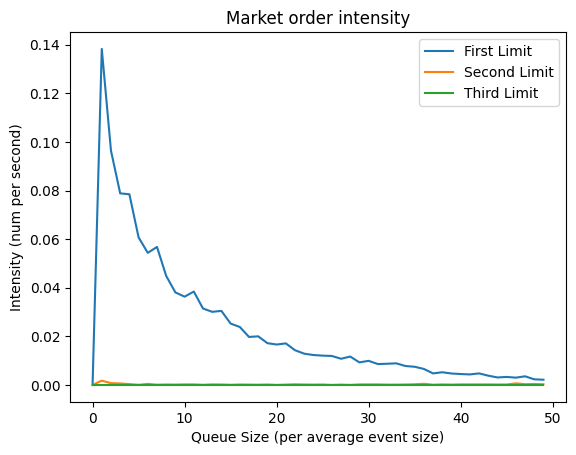

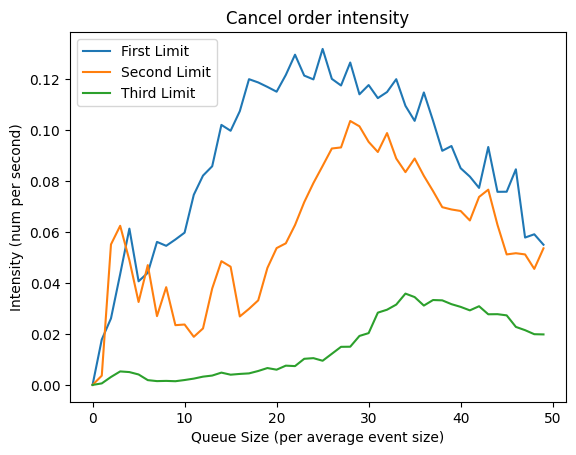

In [23]:
for order_type in range(0, ORDER_TYPES):
    for x in range(0, 2):
        lambdas[0][x][order_type][np.isnan(lambdas[0][x][order_type])] = 0
        lambdas[1][x][order_type][np.isnan(lambdas[1][x][order_type])] = 0
        lambdas[2][x][order_type][np.isnan(lambdas[2][x][order_type])] = 0

    bidIndex = 0
    askIndex = 1

    plt.plot(np.add(lambdas[0][bidIndex][order_type], lambdas[0][askIndex][order_type]), label=f"First Limit")
    plt.plot(np.add(lambdas[1][bidIndex][order_type], lambdas[1][askIndex][order_type]), label=f"Second Limit")
    plt.plot(np.add(lambdas[2][bidIndex][order_type], lambdas[2][askIndex][order_type]), label=f"Third Limit")

    plt.ylabel("Intensity (num per second)")

    plt.xlabel("Queue Size (per average event size)")

    plt.legend()
    
    if (order_type == 0):
        order_name = "Limit"
    elif (order_type == 1):
        order_name = "Market"
    elif (order_type == 2):
        order_name = "Cancel"

    plt.title(f"{order_name} order intensity")

    plt.show()

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]
0.3332323167638478


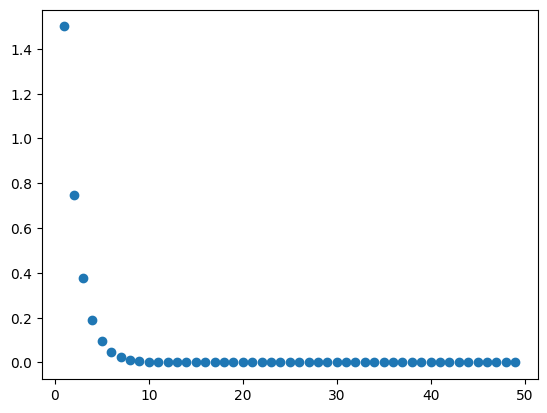

In [20]:
# Invarient Distibutions

def ArrivalDepartureRatio(depth, n, isBid=True):
    bidMarker = 0 if isBid else 1

    limit = lambdas[depth][bidMarker][0][n]
    cancel = lambdas[depth][bidMarker][1][n + 1]
    market = lambdas[depth][bidMarker][2][n + 1]

    return limit / (cancel + market)

def CalculateFirstInvariantTerm(depth, num_of_terms):
    sum = 0

    for n in range(0, num_of_terms):
        product = 1
        for j in range(0, n):
            product *= ArrivalDepartureRatio(depth, j)
        sum += product
    
    return 1 / (1 + sum)

def InvariantDistribution(depth, n, isBid = True):
    product = 1
    for j in range(0, n):
        product *= ArrivalDepartureRatio(depth, j)
    return product / denominator

depth = 1
denominator = CalculateFirstInvariantTerm(depth, 49)

x_vals = np.linspace(1, 49, 49)
y_vals = [InvariantDistribution(depth, int(x)) for x in x_vals]

print(x_vals)
print(denominator)

plt.scatter(x_vals, y_vals)